In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize':16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

In [8]:
data = np.loadtxt("3_gaussians.txt")
df = pd.DataFrame({"x": data[:, 0], "y": data[:, 1], "class": [0] * 100 + [1] * 100 + [2] * 100})
x = df[["x", "y"]]
y = df["class"]

# Naive Bayes

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
classifier = gnb.fit(x_train, y_train)
y_pred_train = classifier.predict(x_train)
y_pred_test = classifier.predict(x_test)
print("Number of mislabeled points out of a total %d training points : %d" % (x_train.shape[0], (y_train != y_pred_train).sum()))
print("Number of mislabeled points out of a total %d test points : %d" % (x_test.shape[0], (y_test != y_pred_test).sum()))

Number of mislabeled points out of a total 240 training points : 3
Number of mislabeled points out of a total 60 test points : 1


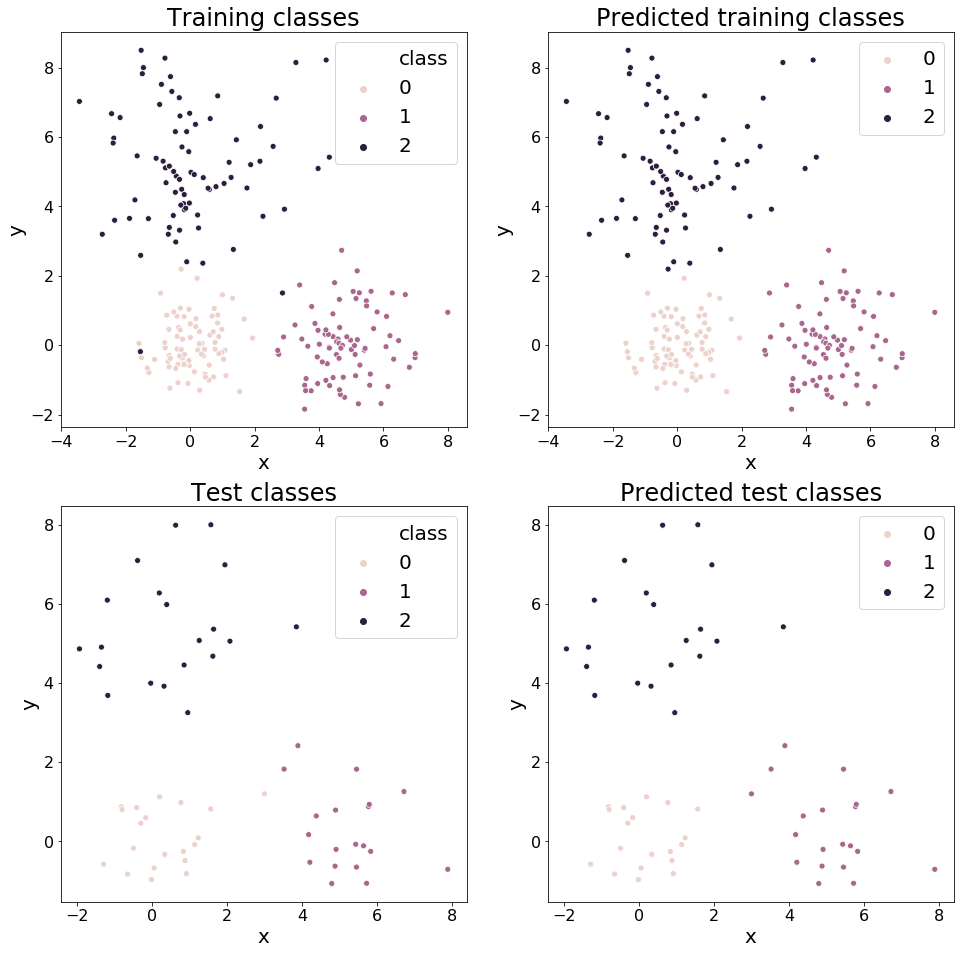

In [32]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.subplot(2, 2, 1)
sns.scatterplot(x=x_train["x"], y=x_train["y"], hue=y_train)
plt.title("Training classes")
plt.subplot(2, 2, 2)
sns.scatterplot(x=x_train["x"], y=x_train["y"], hue=y_pred_train)
plt.title("Predicted training classes")
plt.subplot(2, 2, 3)
sns.scatterplot(x=x_test["x"], y=x_test["y"], hue=y_test)
plt.title("Test classes")
plt.subplot(2, 2, 4)
sns.scatterplot(x=x_test["x"], y=x_test["y"], hue=y_pred_test);
plt.title("Predicted test classes");